In [1]:
import numpy as np
from scipy import sparse
import osqp
import matplotlib.pyplot as plt

In [2]:
def ruiz_equilibriation(matrix, iterations):
    """Preconditioning routine used to make the first-order QP solver converge
    faster. Returns preconditioners to be used to operate on matrices of the QP.

    Args:
        matrix (np.float): Matrix that needs to be preconditioned
        iterations (int): Number of iterations that preconditioner runs for

    Returns:
        left_preconditioner (np.float): The left preconditioning matrix
        right_preconditioner (np.float): The right preconditioning matrix

    """
    m_bar = matrix
    left_preconditioner = sparse.csc_matrix(np.eye(matrix.shape[0]))
    right_preconditioner = sparse.csc_matrix(np.eye(matrix.shape[1]))
    for _ in range(iterations):
        D_l_inv = sparse.csc_matrix(
            np.diag(1 / np.sqrt(np.linalg.norm(m_bar, ord=2, axis=1)))
        )
        if m_bar.shape[0] != m_bar.shape[1]:
            D_r_inv = sparse.csc_matrix(
                np.diag(1 / np.sqrt(np.linalg.norm(m_bar, ord=2, axis=0)))
            )
        else:
            D_r_inv = D_l_inv

        m_bar = D_l_inv @ m_bar @ D_r_inv
        left_preconditioner = left_preconditioner @ D_l_inv
    return left_preconditioner, right_preconditioner

def convert_to_fp(mat, man_bits):
    """Function that returns the exponent, mantissa representation for
    floating point numbers that need to be represented on Loihi. A global exp
    is calculated for the matrices based on the max absolute value in the
    matrix. This is then used to calculate the manstissae in the matrix.

    Args:
        mat (np.float): The input floating point matrix that needs to be
        converted
        man_bits (int): number of bits that the mantissa uses for it's
        representation (Including sign)

    Returns:
        mat_fp_man (np.int): The matrix in
    """
    exp = np.ceil(np.log2(np.max(np.abs(mat)))) - man_bits + 1
    mat_fp_man = (mat // 2**exp).astype(int)
    return mat_fp_man.astype(int), exp.astype(int)

### Single problem from dataset

In [3]:
def solve_qp(dir_name, type="anymal"):

    matrices = np.load(dir_name)
    Q, A, p, k = [matrices[i] for i in matrices]
    
    if type=="anymal":
        # Quasi-static Variables       
        # 0.0625
        alpha_man = 160
        alpha_exp = -8

        #0.00683
        beta_man = 7
        beta_exp = -10
        
        alpha_decay_indices_list = (
            np.array([50, 100, 200, 350, 550, 800, 1100, 1450, 1850, 2300]) * 2
        )
        beta_growth_indices_list = (
            np.array([1, 3, 7, 15, 31, 63, 127, 255, 511, 1023, 2045, 4095])
            * 2
            + 1
        )
        k = k.reshape(k.shape[0], )
        p = p.reshape(p.shape[0], )

    if type=="sim_quad":
        # Quasi-static Variables
        # 0.625
        alpha_man = 160
        alpha_exp = -8
        
        # 0.0125
        beta_man = 7
        beta_exp = -9

        alpha_decay_indices_list = (
            np.array([4, 11 , 25, 46, 74, 109, 151, 200, 256, 319, 389]) * 2
        )
        # alpha_decay_indices_list = (
        #     np.array([50, 100, 200, 350, 550, 800, 1100, 1450, 1850, 2300]) * 2
        # )
        beta_growth_indices_list = (
            np.array([1, 3, 7, 15, 31, 63, 127, 255, 511, 1023, 2045, 4095])
            * 2
            + 1
        )

    
    print(Q.shape, A.shape, p.shape, k.shape)
    # precondition matrices for first-order methods
    (
        pre_mat_Q,
        _,
    ) = ruiz_equilibriation(Q, 5)
    Q_pre = pre_mat_Q @ Q @ pre_mat_Q
    p_pre = pre_mat_Q @ p
    (
        pre_mat_A,
        _,
    ) = ruiz_equilibriation(A, 5)
    A_pre = pre_mat_A @ A @ pre_mat_Q
    k_pre = pre_mat_A @ k

    init_state_x = np.zeros(p.shape).astype(np.int32)
    init_state_w = np.zeros(k.shape).astype(np.int32)

    # ANYmal mu, sigma, lamda
    if type=="anymal":
        k_pre_fp_man, k_pre_fp_exp = k_pre.astype(int), 0  
    
    if type=="sim_quad":
        k_pre_fp_man, k_pre_fp_exp = convert_to_fp(k_pre, 16)
      
    # Quadrotor
    # mu, sigma, lamda = 1, 1, 1

    # mu, sigma, lamda = 1, 447.5, 1

    Q_pre_fp_man, Q_pre_fp_exp = convert_to_fp(Q_pre, 8)
    A_pre_fp_man, A_pre_fp_exp = convert_to_fp(A_pre, 8)
    p_pre_fp_man, p_pre_fp_exp = convert_to_fp(p_pre, 16)

    state_var_x_py = init_state_x
    decay_counter = 0

    state_var_w_py = init_state_w + np.right_shift(
        beta_man * (-np.right_shift(k_pre_fp_man, -k_pre_fp_exp)),
        -beta_exp,
    )
    gamma_py = init_state_w
    growth_counter = 0

    # Control number of iterations with this variable
    iterations = 150 * 2
    
    correction_exp = -min(A_pre_fp_exp, Q_pre_fp_exp)
    print("Correction_exp is {} A_pre_fp_exp is {} and Q_pre_fp_exp is {}".format(correction_exp, A_pre_fp_exp, Q_pre_fp_exp))
    Q_exp_new, A_exp_new = (
        correction_exp + Q_pre_fp_exp,
        correction_exp + A_pre_fp_exp,
    )
    A_pre_fp_man = (A_pre_fp_man // 2) * 2
    Q_pre_fp_man = (Q_pre_fp_man // 2) * 2
    cost = []
    constraint_sat = []
    for i in range(1, iterations):
        a_in_pg_1 = (A_pre_fp_man).T @ gamma_py

        a_in_pg_1 = np.left_shift(a_in_pg_1, A_exp_new)

        a_in_pg_2 = Q_pre_fp_man @ state_var_x_py
        a_in_pg_2 = np.left_shift(a_in_pg_2, Q_exp_new)

        a_in_pg = a_in_pg_1 + a_in_pg_2
        a_in_pg = np.right_shift(a_in_pg, correction_exp)

        decay_counter += 1
        if decay_counter % 2 == 0:
            if decay_counter in alpha_decay_indices_list:
                alpha_man //= 2
            tot_bias_gd = alpha_man * (
                a_in_pg + np.right_shift(p_pre_fp_man, -p_pre_fp_exp)
            )

            x_inter = np.right_shift(tot_bias_gd, -alpha_exp)

            state_var_x_py -= x_inter
            
            # Logging data to plot later
            curr_post_sol = pre_mat_Q@state_var_x_py
            cost.append(curr_post_sol.T@Q@curr_post_sol/2 + p.T@curr_post_sol)
            constraint_sat.append(np.linalg.norm(A@curr_post_sol - k))
            # sol_list.append(state_var_x_py)
        a_in_pi = A_pre_fp_man @ state_var_x_py
        a_in_pi = np.right_shift(a_in_pi, -A_pre_fp_exp)

        growth_counter += 1
        if growth_counter % 2 == 1:
            if growth_counter in beta_growth_indices_list:
                beta_man *= 2
            tot_bias_pi = beta_man * (
                a_in_pi - np.right_shift(k_pre_fp_man, -k_pre_fp_exp)
            )
        
            omega = np.right_shift(tot_bias_pi, -beta_exp)
            state_var_w_py += omega
            gamma_py = state_var_w_py + omega

    fig,ax = plt.subplots()
    ax.plot(np.array(cost[:]), color="red")
    ax.set_ylabel("$z^T H z/2 + h^T z $",color="red",fontsize=14)
    ax.set_xlabel("Iterations",fontsize=14)

    ax2=ax.twinx()
    ax2.set_yscale('log')
    ax2.plot(constraint_sat,color="blue")
    ax2.set_ylabel("$||Gz-g||_2$",color="blue",fontsize=14)
    plt.show()

    prob = osqp.OSQP()
    prob.setup(sparse.csc_matrix(Q), p, sparse.csc_matrix(A), k, k)
    res = prob.solve()

    print("The constraint violation is {}".format(np.linalg.norm(constraint_sat[-1])))
    print("Optimal cost from Loihi solver is {} and osqp is {}".format(cost[-1], res.info.obj_val))

---------------ANYMAL-----------------
(264, 264) (144, 264) (264,) (144,)
Correction_exp is 6 A_pre_fp_exp is -5 and Q_pre_fp_exp is -6


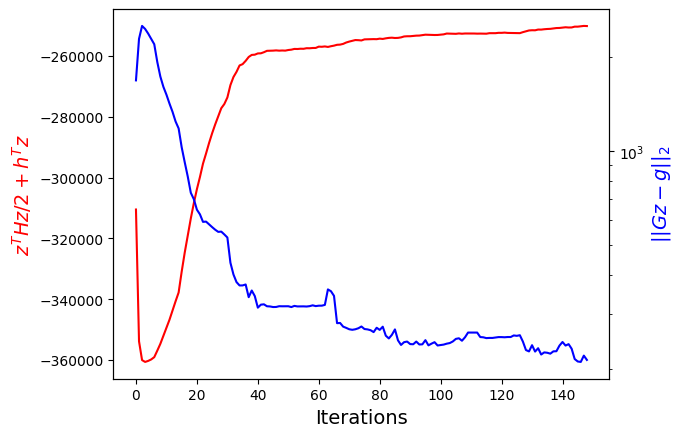

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 264, constraints m = 144
          nnz(P) + nnz(A) = 1443
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5134e+05   1.42e-01   7.23e+00   1.00e-01   3.17e-04s
  25  -2.3595e+05   1.62e-05   3.35e-05   1.00e-01   4.95e-04s

status:               solved
number of iter

In [7]:

print("---------------ANYMAL-----------------")
solve_qp(dir_name="NeuRIPS_data/anymal_quadruped/01_anymal_small_scale/mpc_240_1500.npz", 
         type="anymal")

----------------QUAD-------------------
(172, 172) (132, 172) (172,) (132,)
Correction_exp is 6 A_pre_fp_exp is -6 and Q_pre_fp_exp is -6


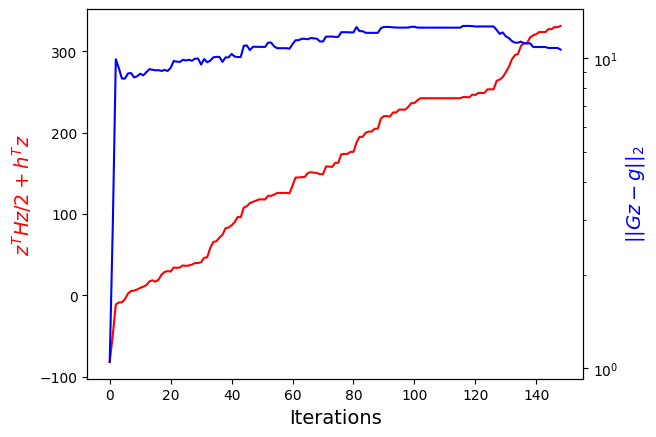

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 172, constraints m = 132
          nnz(P) + nnz(A) = 884
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -3.6345e+01   9.54e-01   1.77e+03   1.00e-01   2.06e-04s
  25  -4.9564e+01   1.94e-04   8.40e-03   1.00e-01   3.18e-04s

status:               solved
number of itera

In [9]:
print("----------------QUAD-------------------")
solve_qp(dir_name="NeuRIPS_data/simulated_quadrotor/01_sim_quad_small_scale/mpc_172_100.npz", 
         type="sim_quad")